In [112]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image, FileLink
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [113]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz


In [114]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

.\notMNIST_large already present - Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small already present - Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


# Problem 1

In [115]:
local_file = FileLink('.\\notMNIST_large\\A\\Q29uY29yZGVCUS1NZWRpdW0ub3Rm.png')
display(local_file)

C:\Users\irdi1\Desktop\thesis-work\UdacityDL\L1\Assignment 1\notMNIST_large\A\Q29uY29yZGVCUS1NZWRpdW0ub3Rm.png

In [116]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

.\notMNIST_large\A.pickle already present - Skipping pickling.
.\notMNIST_large\B.pickle already present - Skipping pickling.
.\notMNIST_large\C.pickle already present - Skipping pickling.
.\notMNIST_large\D.pickle already present - Skipping pickling.
.\notMNIST_large\E.pickle already present - Skipping pickling.
.\notMNIST_large\F.pickle already present - Skipping pickling.
.\notMNIST_large\G.pickle already present - Skipping pickling.
.\notMNIST_large\H.pickle already present - Skipping pickling.
.\notMNIST_large\I.pickle already present - Skipping pickling.
.\notMNIST_large\J.pickle already present - Skipping pickling.
.\notMNIST_small\A.pickle already present - Skipping pickling.
.\notMNIST_small\B.pickle already present - Skipping pickling.
.\notMNIST_small\C.pickle already present - Skipping pickling.
.\notMNIST_small\D.pickle already present - Skipping pickling.
.\notMNIST_small\E.pickle already present - Skipping pickling.
.\notMNIST_small\F.pickle already present - Skipping pi

# Problem 2

In [117]:
print(train_datasets[0])
print(train_datasets[2])
print(train_datasets[3])


A = pickle.load( open( train_datasets[0], "rb" ) )

C = pickle.load( open( train_datasets[2], "rb" ) )
D = pickle.load( open( train_datasets[3], "rb" ) )
print(np.shape(A))
print(np.shape(C))
print(np.shape(D))



.\notMNIST_large\A.pickle
.\notMNIST_large\C.pickle
.\notMNIST_large\D.pickle
(52909, 28, 28)
(52912, 28, 28)
(52911, 28, 28)


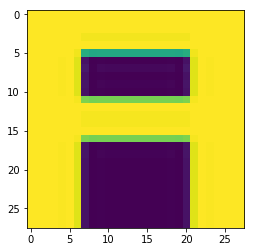

In [118]:
imgplot = plt.imshow(A[52])


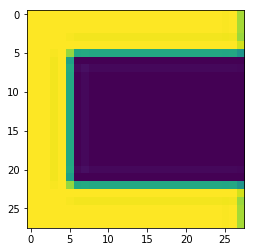

In [119]:
imgplot1 = plt.imshow(C[3])


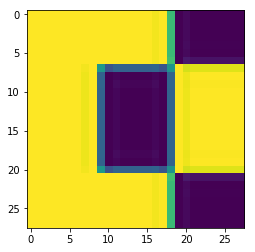

In [120]:
imgplot2 = plt.imshow(D[41])

# Problem 3

In [121]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [122]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

# Problem 4

In [123]:
np.shape(train_dataset)

(200000, 28, 28)

5


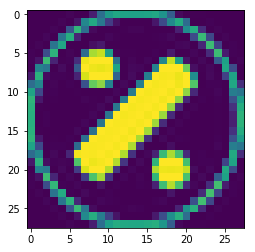

In [124]:
print(train_labels[52])
imgplot = plt.imshow(train_dataset[52])

3


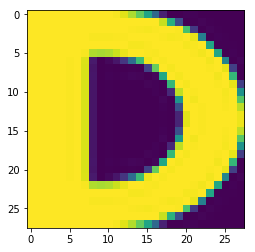

In [125]:
print(train_labels[200])
imgplot = plt.imshow(train_dataset[200])

[[-0.5        -0.5        -0.5        -0.5        -0.5        -0.49607843
  -0.48823529 -0.5        -0.5        -0.44509804 -0.22156863  0.04117647
   0.23333333  0.40196079  0.5         0.5         0.5         0.44509804
   0.32745099  0.20980392  0.06078431 -0.17843138 -0.39411765 -0.5        -0.5
  -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.49215686 -0.5        -0.5
  -0.38627452  0.01372549  0.34313726  0.5         0.5         0.5
   0.39411765  0.30784315  0.28823531  0.33137256  0.45294118  0.5         0.5
   0.5         0.5         0.41764706  0.1509804  -0.30392158 -0.5
  -0.49215686 -0.5       ]
 [-0.5        -0.5        -0.5        -0.49215686 -0.5        -0.48431373
  -0.01372549  0.43333334  0.5         0.5         0.37450981 -0.00196078
  -0.30000001 -0.45294118 -0.5        -0.5        -0.49215686 -0.37843138
  -0.14313726  0.2764706   0.5         0.49215686  0.5         0.5
   0.05294118 -0.5        -0.48431373 -0.5       ]
 

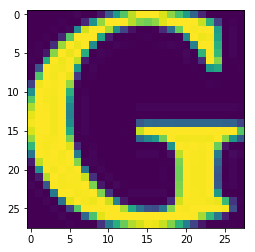

In [126]:
print(test_dataset[200])
imgplot = plt.imshow(test_dataset[200])

(10000, 28, 28)

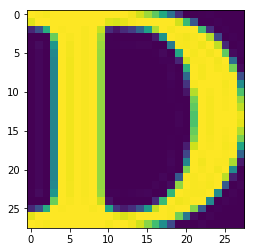

In [127]:
imgplot = plt.imshow(valid_dataset[200])
np.shape(valid_dataset)

In [128]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [129]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


# Problem 5

In [130]:
def overlap_indices(images1, images2):
    hash1 = set([image1.tobytes() for image1 in images1])
    hash2 = set([image2.tobytes() for image2 in images2])
    ind_dict = dict((k,i) for i,k in enumerate(hash1))
    all_overlaps = set(ind_dict).intersection( hash2)
    indices = [ ind_dict[x] for x in all_overlaps ]
    return indices

i_ts_tr = overlap_indices(test_dataset,train_dataset) 
i_tr_ts = overlap_indices(train_dataset, test_dataset)    
print('Number of overlaps between training and test sets: {}.'.format(len(i_tr_ts)))

i_va_tr = overlap_indices(valid_dataset, train_dataset)
i_tr_va = overlap_indices(train_dataset, valid_dataset)   
print('Number of overlaps between training and validation sets: {}.'.format(len(i_tr_va)))

i_ts_va = overlap_indices(test_dataset, valid_dataset)
i_va_ts = overlap_indices(valid_dataset, test_dataset) 
print('Number of overlaps between validation and test sets: {}.'.format(len(i_va_ts)))


Number of overlaps between training and test sets: 1153.
Number of overlaps between training and validation sets: 953.
Number of overlaps between validation and test sets: 55.


In [149]:
sanitized_valid_dataset = np.delete(valid_dataset,i_va_tr,0)
sanitized_valid_labels = np.delete(valid_labels,i_va_tr,0)
half_sanitized_test_dataset = np.delete(test_dataset,i_ts_tr,0)
half_sanitized_test_labels = np.delete(test_labels,i_ts_tr,0)

In [132]:
i_sts_sva = overlap_indices(half_sanitized_test_dataset, sanitized_valid_dataset)
print('Number of overlaps between sanitized validation and sanitized test sets: {}.'.format(len(i_sts_sva)))

Number of overlaps between sanitized validation and sanitized test sets: 40.


In [150]:
sanitized_test_dataset = np.delete(half_sanitized_test_dataset,i_sts_sva,0)
sanitized_test_labels = np.delete(half_sanitized_test_labels,i_sts_sva,0)


overlap_indices(images1, images2) returns the indices of images1 that are present in images2 as well. These indices are used for sanitizing the validation and test sets.


# Problem 6

In [134]:
shape_td = np.shape(train_dataset)
shape_va = np.shape(valid_dataset)
shape_ts = np.shape(test_dataset)
shape_sva = np.shape(sanitized_valid_dataset)
shape_sts = np.shape(sanitized_test_dataset)

In [136]:

train_dataset = np.reshape(train_dataset,(shape_td[0],shape_td[1] * shape_td[2]))
valid_dataset = np.reshape(valid_dataset,(shape_va[0],shape_va[1] * shape_va[2]))
test_dataset = np.reshape(test_dataset,(shape_ts[0],shape_ts[1] * shape_ts[2]))

sanitized_valid_dataset = np.reshape(sanitized_valid_dataset,(shape_sva[0],shape_sva[1] * shape_sva[2]))
sanitized_test_dataset = np.reshape(sanitized_test_dataset,(shape_sts[0],shape_sts[1] * shape_sts[2]))
np.shape(test_dataset)

(10000, 784)

In [152]:
import sklearn

LogRegMod50 = sklearn.linear_model.LogisticRegression()
LogRegMod50.fit(train_dataset[:50],train_labels[:50])

prediction50 = LogRegMod50.predict(test_dataset[:50])
print(sklearn.metrics.accuracy_score(test_labels[:50], prediction50))

spred50 = LogRegMod50.predict(sanitized_test_dataset[:50])
print(sklearn.metrics.accuracy_score(sanitized_test_labels[:50], spred50))


0.46
0.4


In [153]:
LogRegMod100 = sklearn.linear_model.LogisticRegression()
LogRegMod100.fit(train_dataset[:100],train_labels[:100])

prediction100 = LogRegMod100.predict(test_dataset[:100])
print(sklearn.metrics.accuracy_score(test_labels[:100], prediction100))

spred100 = LogRegMod100.predict(sanitized_test_dataset[:100])
print(sklearn.metrics.accuracy_score(sanitized_test_labels[:100], spred100))


0.64
0.65


In [155]:
LogRegMod1000 = sklearn.linear_model.LogisticRegression()
LogRegMod1000.fit(train_dataset[:1000],train_labels[:1000])

prediction1000 = LogRegMod1000.predict(test_dataset[:1000])
print(sklearn.metrics.accuracy_score(test_labels[:1000], prediction1000))

spred1000 = LogRegMod1000.predict(sanitized_test_dataset[:1000])
print(sklearn.metrics.accuracy_score(sanitized_test_labels[:1000], spred1000))


0.839
0.849


In [156]:
LogRegMod5000 = sklearn.linear_model.LogisticRegression()
LogRegMod5000.fit(train_dataset[:5000],train_labels[:5000])

prediction5000 = LogRegMod5000.predict(test_dataset[:5000])
print(sklearn.metrics.accuracy_score(test_labels[:5000], prediction5000))

spred5000 = LogRegMod5000.predict(sanitized_test_dataset[:5000])
print(sklearn.metrics.accuracy_score(sanitized_test_labels[:5000], spred5000))


0.8526
0.853


In [157]:
LogRegMod= sklearn.linear_model.LogisticRegression()
LogRegMod.fit(train_dataset,train_labels)

prediction = LogRegMod.predict(test_dataset)
print(sklearn.metrics.accuracy_score(test_labels, prediction))

spred = LogRegMod.predict(sanitized_test_dataset)
print(sklearn.metrics.accuracy_score(sanitized_test_labels, spred))


0.8933
0.894742818213
